In [135]:
import pandas as pd
import numpy as np
from google.cloud import bigquery
from google.oauth2 import service_account
from sklearn.impute import KNNImputer
from sklearn.preprocessing import LabelEncoder
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
import math
import pickle
import config

# Import

In [47]:
#load credentials
credentials = service_account.Credentials.from_service_account_file(config.credentials)
client = bigquery.Client(credentials=credentials, project=credentials.project_id)

# Load SQL query into a variable
with open('query.sql', 'r') as file:
    sql = file.read()

#save data to datafram
df = client.query(sql).to_dataframe()

In [3]:
df.head()

,id,date,address,link,page_num,neighborhood,bedrooms,bathrooms,monthly_rent,square_feet,walking_score,bike_score,transit_score
0,north-10,2024-10-20,"853 W Blackhawk St, Chicago, IL 60642",https://www.apartments.com/post-chicago-il/bdv...,1,Lincoln Park,4,3,3799,1279,91,89,77
1,north-11,2024-10-20,"400 E South Water St, Chicago, IL 60601",https://www.apartments.com/shoreham-and-tides-...,1,Lake Shore East,2,2,6189,1350,90,84,98
2,north-12,2024-10-20,"930 W Altgeld St, Chicago, IL 60614",https://www.apartments.com/elevate-chicago-il/...,1,DePaul,3,2.5,14670,2616,96,85,80
3,north-13,2024-10-20,"1457 N Halsted St, Chicago, IL 60642",https://www.apartments.com/the-residences-at-n...,1,Old Town,2,2,4570,1315,95,89,78
4,north-14,2024-10-20,"808 N Cleveland Ave, Chicago, IL 60610",https://www.apartments.com/the-808-cleveland-c...,1,River North,4,3,5529,1578,97,83,82


In [26]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1400 entries, 0 to 1399
Data columns (total 13 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   id             1400 non-null   object
 1   date           1400 non-null   dbdate
 2   address        1400 non-null   object
 3   link           1400 non-null   object
 4   page_num       1400 non-null   Int64 
 5   neighborhood   1400 non-null   object
 6   bedrooms       1400 non-null   int64 
 7   bathrooms      1400 non-null   int64 
 8   monthly_rent   1377 non-null   object
 9   square_feet    1159 non-null   object
 10  walking_score  1400 non-null   int64 
 11  bike_score     1400 non-null   int64 
 12  transit_score  1400 non-null   int64 
dtypes: Int64(1), dbdate(1), int64(5), object(6)
memory usage: 143.7+ KB


#Data Cleaning

In [57]:
df = df.drop(columns=['date','page_num']) #drop columns not needed for reference

#change number columns to numeric dtypes
df[['bedrooms','bathrooms','monthly_rent','square_feet','walking_score','bike_score','transit_score']] = df[['bedrooms','bathrooms','monthly_rent','square_feet','walking_score','bike_score','transit_score']].apply(pd.to_numeric)

In [59]:
#label encode neighborhood

# Initialize LabelEncoder
label_encoder = LabelEncoder()

# Encode 'neighborhood' column
df['neighborhood_encoded'] = label_encoder.fit_transform(df['neighborhood'])

In [68]:
#fill null monthly_rent and square feet with knn

# 1. Drop string columns
df_numeric = df.select_dtypes(exclude=['object'])

# 2. Apply KNN Imputer to fill missing values
knn_imputer = KNNImputer(n_neighbors=10) #larger value of 10 since some neighborhoods don't have many listings
df_imputed_values = knn_imputer.fit_transform(df_numeric)
df_imputed = pd.DataFrame(df_imputed_values, columns=df_numeric.columns)

# 3. Optionally, combine back with the original string columns (optional)
df_final = pd.concat([df_imputed, df.select_dtypes(include=['object'])], axis=1)

# Exploratory Data Analysis

In [74]:
df_final.describe()

,bedrooms,bathrooms,monthly_rent,square_feet,walking_score,bike_score,transit_score,neighborhood_encoded
count,1400.000000,1400.000000,1400.000000,1400.000000,1400.000000,1400.000000,1400.000000,1400.000000
mean,2.040714,1.522143,3202.253929,1049.770786,88.070000,83.147143,76.265714,77.041429
std,0.989104,0.743720,5293.331687,632.297529,12.206033,12.495594,15.832151,35.367019
min,1.000000,0.500000,650.000000,66.000000,10.000000,30.000000,0.000000,0.000000
25%,1.000000,1.000000,1650.000000,700.000000,83.000000,80.000000,67.000000,49.750000
50%,2.000000,1.000000,2300.000000,931.800000,93.000000,87.000000,75.000000,80.000000
75%,3.000000,2.000000,3322.500000,1231.000000,96.000000,92.000000,88.000000,109.000000
max,7.000000,9.000000,150000.000000,9324.000000,100.000000,99.000000,100.000000,128.000000


<Axes: ylabel='Frequency'>

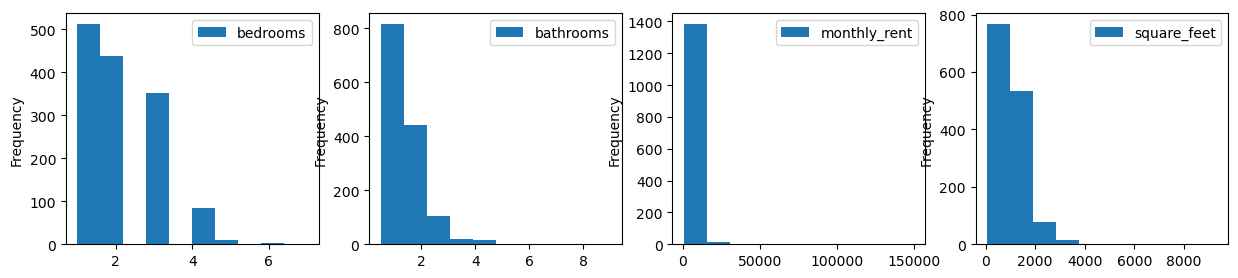

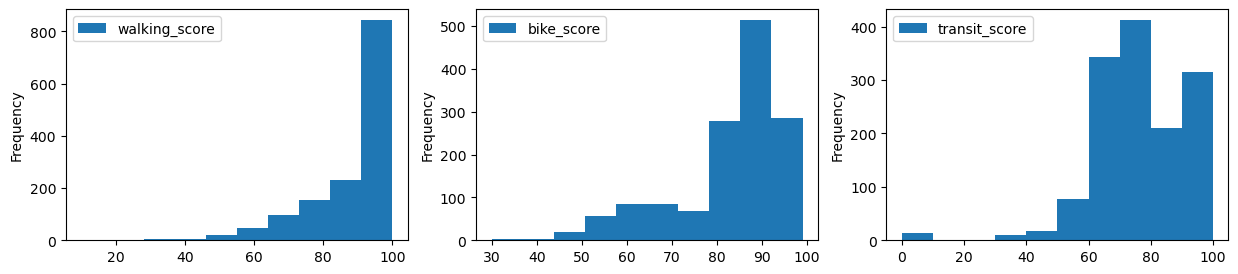

In [85]:
fig, (ax1,ax2,ax3,ax4) = plt.subplots(1,4, figsize=(15,3))
df_final.plot(kind='hist',y='bedrooms',ax=ax1)
df_final.plot(kind='hist',y='bathrooms',ax=ax2)
df_final.plot(kind='hist',y='monthly_rent',ax=ax3)
df_final.plot(kind='hist',y='square_feet',ax=ax4)

fig, (ax1,ax2,ax3) = plt.subplots(1,3, figsize=(15,3))
df_final.plot(kind='hist',y='walking_score',ax=ax1)
df_final.plot(kind='hist',y='bike_score',ax=ax2)
df_final.plot(kind='hist',y='transit_score',ax=ax3)

<Axes: xlabel='transit_score', ylabel='monthly_rent'>

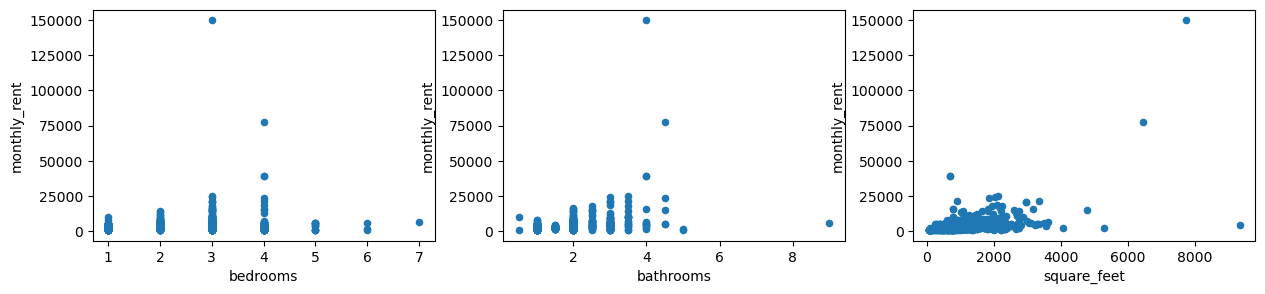

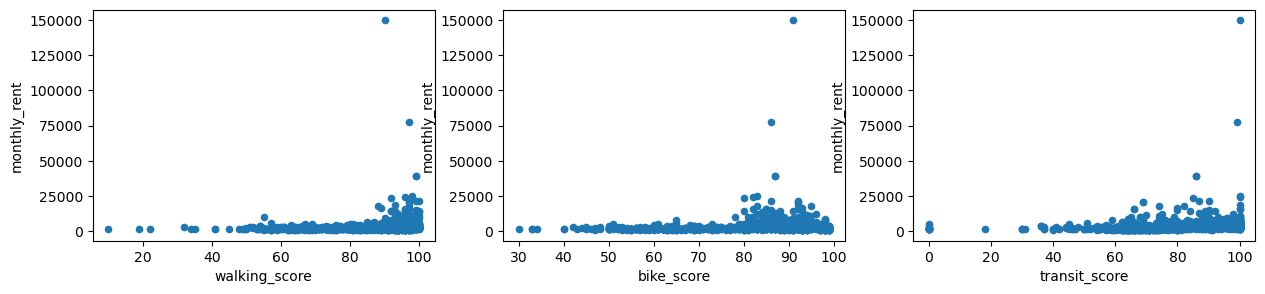

In [87]:
fig, (ax1,ax2,ax3) = plt.subplots(1,3, figsize=(15,3))
df_final.plot(kind='scatter',x='bedrooms',y='monthly_rent',ax=ax1)
df_final.plot(kind='scatter',x='bathrooms',y='monthly_rent',ax=ax2)
df_final.plot(kind='scatter',x='square_feet',y='monthly_rent',ax=ax3)

fig, (ax1,ax2,ax3) = plt.subplots(1,3, figsize=(15,3))
df_final.plot(kind='scatter',x='walking_score',y='monthly_rent',ax=ax1)
df_final.plot(kind='scatter',x='bike_score',y='monthly_rent',ax=ax2)
df_final.plot(kind='scatter',x='transit_score',y='monthly_rent',ax=ax3)

There look to be heavy outliers for monthly rent and square feet. These should be removed from the analysis.

In [89]:
def outliers_iqr(df,column):

    # Calculate Q1 (25th percentile) and Q3 (75th percentile)
    Q1 = df[column].quantile(0.25)
    Q3 = df[column].quantile(0.75)

    # Calculate IQR
    IQR = Q3 - Q1

    # Define lower and upper bounds
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR

    # Exclude outliers
    df_filtered = df[(df[column] >= lower_bound) & (df[column] <= upper_bound)]

    return df_filtered

In [91]:
df_final2 = outliers_iqr(df_final,'monthly_rent') #remove monthly rent outliers
df_final2 = outliers_iqr(df_final2,'square_feet') #take result, then remove square feet outliers

The resulting distributions look much more normal than before

<Axes: ylabel='Frequency'>

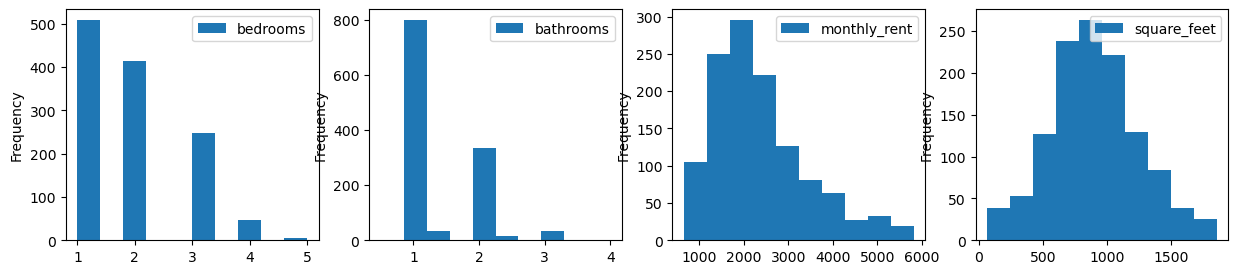

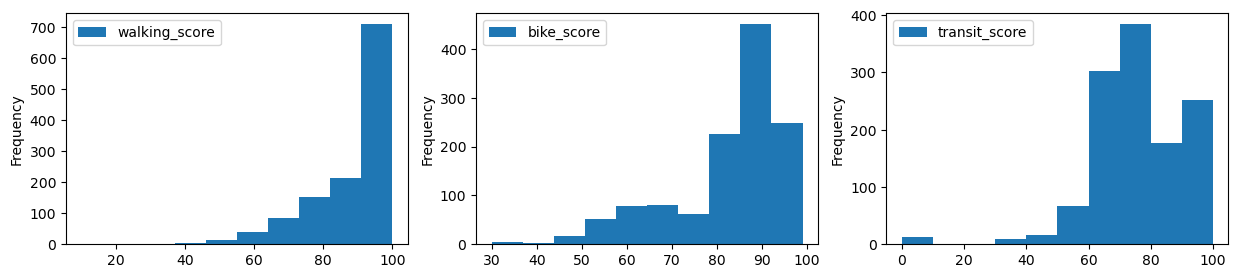

In [99]:
fig, (ax1,ax2,ax3,ax4) = plt.subplots(1,4, figsize=(15,3))
df_final2.plot(kind='hist',y='bedrooms',ax=ax1)
df_final2.plot(kind='hist',y='bathrooms',ax=ax2)
df_final2.plot(kind='hist',y='monthly_rent',ax=ax3)
df_final2.plot(kind='hist',y='square_feet',ax=ax4)

fig, (ax1,ax2,ax3) = plt.subplots(1,3, figsize=(15,3))
df_final2.plot(kind='hist',y='walking_score',ax=ax1)
df_final2.plot(kind='hist',y='bike_score',ax=ax2)
df_final2.plot(kind='hist',y='transit_score',ax=ax3)

<Axes: >

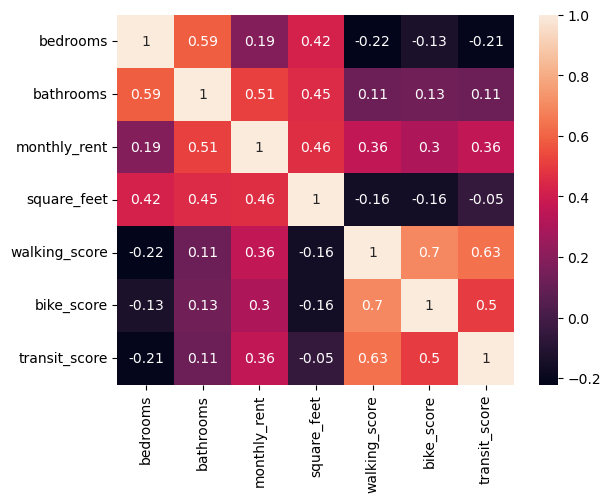

In [96]:
sns.heatmap(df_final2.drop(columns=['neighborhood_encoded']).select_dtypes(exclude=['object']).corr(),annot=True)

Note: first run through this exercise found heteroscadicty (residuals increasing with predicted target variable). To help control for this, transform the target variable with log.

In [123]:
df_final2['log_monthly_rent'] = np.log(df_final2['monthly_rent'])

# Modeling

## Model Creation

Goal is to model the relationship between the numeric data points and monthly rent

First, attempting a linear regression model. Not including neighborhood_encoded as a higher/lower value does not correspond to anything location wise.

Seen below, the model returned a r2 of .52. All the independent variables are statistically signifcant.

In [124]:
X = df_final2.loc[:,['bedrooms','bathrooms','square_feet','walking_score','bike_score','transit_score']]
y = df_final2['log_monthly_rent']
X = sm.add_constant(X)

result = sm.OLS(y,X).fit()
print(result.summary())

                            OLS Regression Results                            
Dep. Variable:       log_monthly_rent   R-squared:                       0.521
Model:                            OLS   Adj. R-squared:                  0.519
Method:                 Least Squares   F-statistic:                     220.0
Date:                Fri, 25 Oct 2024   Prob (F-statistic):          5.53e-190
Time:                        15:22:26   Log-Likelihood:                -286.04
No. Observations:                1220   AIC:                             586.1
Df Residuals:                    1213   BIC:                             621.8
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
const             5.5805      0.080     69.696

Will next attempt a Random Forest model. This way we can include the label encoded neighborhoods, and model non-linear relationships.

Below first attmempt shows a resulting r2 of .66 on the test data, a better result.

In [127]:
X = df_final2.loc[:,['bedrooms','bathrooms','square_feet','walking_score','bike_score','transit_score','neighborhood_encoded']]
y = df_final2['log_monthly_rent']

X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.3)

model = RandomForestRegressor(random_state=22)
model.fit(X_train,y_train)

print(
    model.score(X_train,y_train),
    model.score(X_test,y_test)
)

pd.DataFrame({'Feature':X.columns, 'Importance':model.feature_importances_}).sort_values(by='Importance',ascending=False)

0.9533081094723561 0.6612643054553939


,Feature,Importance
2,square_feet,0.337632
1,bathrooms,0.221454
5,transit_score,0.170661
4,bike_score,0.114104
3,walking_score,0.088819
6,neighborhood_encoded,0.046636
0,bedrooms,0.020694


Now, will tune the hyperparameters through grid search to see if we can improve the model.

In [128]:
#Hyperparameter tuning

param_grid = {
    'n_estimators':[50,100,150], #number of trees,
    'max_depth':[5,7,10], #max depth of the trees,
    'min_samples_split':[2,3,4], #min number of samples required to split an internal node
    'min_samples_leaf':[1,2,3], #min number of samples required to be at a leaf node
    'max_features':[.3,.4,.5] #number of features to select
}

#Perfrom grid search with cross val
grid_search = GridSearchCV(estimator=model, param_grid=param_grid, cv=5, scoring='r2')
grid_search.fit(X_train,y_train)

print("Best Hyperparameters:", grid_search.best_params_)

#best model on the test set
best_model = grid_search.best_estimator_
y_pred = best_model.predict(X_test)
r2 = r2_score(y_test,y_pred)
print('R2 score =', r2)

pd.DataFrame({'Feature':X.columns, 'Importance':best_model.feature_importances_}).sort_values(by='Importance',ascending=False)

Best Hyperparameters: {'max_depth': 10, 'max_features': 0.3, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 150}
R2 score = 0.6789154100475634


,Feature,Importance
2,square_feet,0.285538
5,transit_score,0.172561
1,bathrooms,0.166964
4,bike_score,0.137536
3,walking_score,0.110319
0,bedrooms,0.065323
6,neighborhood_encoded,0.061761


After tuning, we can see that square_feet and transit_score are the most important variables in the model. This can be understood as square footage and available transit options have the highest impact on monthly rent. From the data exploration and linear regression, we can see both have a positive relationship with monthly rent. As square footage and transit availability increase, rent will also increase. This makes sense logically.

## Model Evaluation

In [129]:
mse = np.mean((best_model.predict(X_test) - y_test)**2)
print('MSE = ', mse)

MSE =  0.062962980877226


In [130]:
rmse = math.sqrt(mse)
print('RMSE = ',rmse)

RMSE =  0.2509242532662517


Residual plot passes the visual test. No clear pattern between residuals and predicted rent

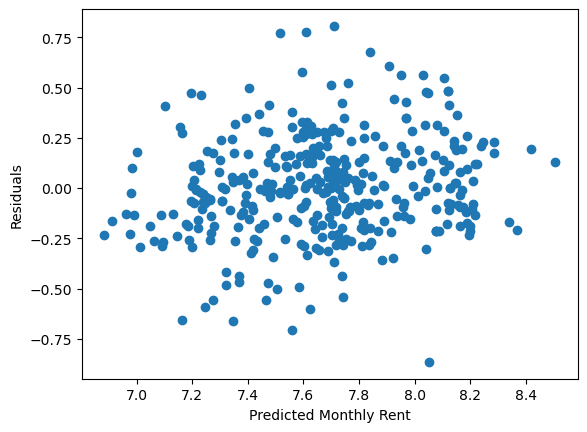

In [131]:
residuals = y_test - y_pred

plt.scatter(y_pred,residuals)

plt.xlabel("Predicted Monthly Rent")
plt.ylabel("Residuals")

plt.show()

<Axes: >

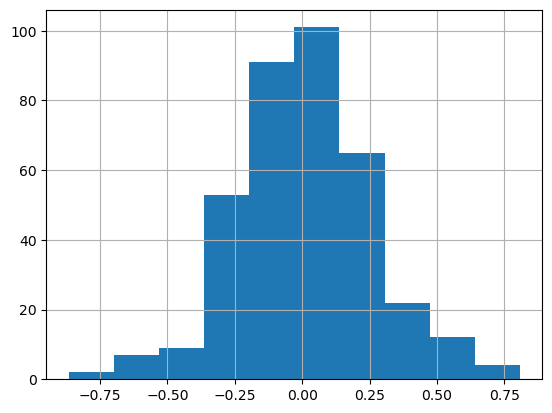

In [132]:
residuals.hist()

In [133]:
k = 5
cv_scores = cross_val_score(best_model, X, y, cv=k, scoring='r2')
print('R2 score', cv_scores)

R2 score [0.6564011  0.58800701 0.68384341 0.76596268 0.68103907]


## Model export

In [136]:
filename = 'chicago_monthly_rent.sav'
pickle.dump(best_model, open(filename, 'wb'))

# Prediction

The model can be used for predict monthly rent for an apartment. Update the variables below to get the prediction

In [ ]:
def get_predicted_rent(neighborhood,bedrooms,bathrooms,square_feet,transit_score,walking_score,biking_score):

    #get the neighborhood label code from the data. Must exactly match
    neighborhood_code = df_final2.loc[df_final2['neighborhood']==neighborhood]['neighborhood_encoded'].max()

    #load the model
    model = pickle.load(open('chicago_monthly_rent.sav','rb'))

    #pass the inputs in same order as training
    X = pd.DataFrame(
        [{
            'bedrooms':bedrooms,
            'bathrooms':bathrooms,
            'square_feet':square_feet,
            'walking_score':walking_score,
            'bike_score':biking_score,
            'transit_score':transit_score,
            'neighborhood_encoded':neighborhood_code
        }]
    )

    #convert to floats, as they were during training
    X = X.astype(float)

    #get inverse of log, as the model predicts log rent
    pred = np.e**model.predict(X)[0]

    #round the result to 2 decimal points
    return round(pred,2)

In [164]:
neighborhood = 'Wicker Park'
bedrooms = 2
bathrooms = 2
square_feet = 1000
transit_score = 90
walking_score = 90
biking_score = 90

predition = get_predicted_rent(
    neighborhood=neighborhood,
    bedrooms=bedrooms,
    bathrooms=bathrooms,
    square_feet=square_feet,
    transit_score=transit_score,
    walking_score=walking_score,
    biking_score=biking_score
)

print('Predicted Monthly Rent: $',predition)

Predicted Monthly Rent: $ 2910.41
